## Monthly Short Term Interest Rate Prediction
Data: 1973 - 2023
Potential Predictors: 'Personal Income', 'Industrial Production', 'Money Supply- Currency/Demand Deposit/Traveller Check', 'Money Supply- Deposit'

## Research Question and Rationale

### Research Question:

We include the following economic indicators in our analysis to answer the question:

**How do various economic indicators, including Personal Income, GDP, Consumer Prices, Industrial Production, and Consumer Confidence, influence or correlate with changes in interest rates in the United States?**

### Rationale for Including Each Data Point:

1. **Personal Income (Percent change vs. 1 period ago - annualized):**
   - **Rationale:** We incorporate Personal Income data to gauge the financial well-being of individuals. Changes in personal income can influence consumer spending and saving behavior, which, in turn, can impact the overall economy and interest rates. This data provides insights into the economic health of individuals.

2. **GDP (Latest Median):**
   - **Rationale:** Gross Domestic Product (GDP) is a key indicator of a nation's economic performance. It measures the total value of goods and services produced in a country. Changes in GDP can indicate economic growth or contraction, and these changes often lead to monetary policy adjustments, including changes in interest rates.

3. **Consumer Prices (U.S. Bureau of Labor Statistics):**
   - **Rationale:** Consumer prices, as measured by inflation, have a direct impact on interest rates. Central banks often use interest rates to control inflation. An increase in consumer prices can lead to higher interest rates, and a decrease can result in lower rates. Monitoring inflation is essential for understanding interest rate movements.

4. **Industrial Production (Federal Reserve System):**
   - **Rationale:** Industrial production is a measure of the output of the industrial sector, including manufacturing, mining, and utilities. Changes in industrial production can indicate shifts in economic activity, which can, in turn, influence interest rates. A strong industrial sector may lead to increased borrowing and higher interest rates.

5. **Consumer Confidence (The Conference Board):**
   - **Rationale:** Consumer confidence reflects the sentiment and outlook of consumers about the economy. High consumer confidence can lead to increased spending and borrowing, affecting the demand for loans and potentially leading to changes in interest rates. Monitoring consumer confidence helps assess economic sentiment.

By including these data points in our analysis, we aim to explore the relationship between various economic indicators and interest rates. This research can help identify potential causal factors, correlations, and trends that provide valuable insights into the dynamics of the financial markets and monetary policy in the United States.


In [75]:
!pip install numpy pandas statsmodels matplotlib scikit-learn pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Use Dates as indexes

In [76]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()  # allows using dates for indexing

In [106]:
# from interesrate.csv, read the following columns into df: Date, Short Term Interest Rates, Personal Income,	Consumer Prices(Inflation,)	Industrial Production,	Consumer Confidence,	Money Supply- Currency/Demand Deposit/Traveller Check,	Money Supply- Deposit

df_orig = pd.read_csv(
    "interestdata.csv",
    parse_dates=["Date"],
    index_col=["Date"],
    usecols=[
        "Date",
        "Short Term Interest Rates",
        "Personal Income",
        "Industrial Production",
        "Money Supply- Currency/Demand Deposit/Traveller Check",
        "Money Supply- Deposit",
    ],
)

In [77]:
df = df_orig.copy()

df.dropna(inplace=True)

In [78]:
df.describe()

,Short Term Interest Rates,Personal Income,Industrial Production,Money Supply- Currency/Demand Deposit/Traveller Check,Money Supply- Deposit
count,600.000000,600.000000,600.000000,600.000000,600.000000
mean,4.972750,7.672099,77.161705,2528.172832,6467.017172
std,3.916447,37.325050,21.206874,4594.927097,5418.529386
min,0.090000,-81.049850,39.952099,257.899994,839.299988
25%,1.347500,3.371865,55.026525,631.425003,2528.050049
50%,5.150000,5.883719,85.067749,1117.599976,4248.150147
75%,7.030000,8.792834,98.016724,1876.699982,8901.050293
max,18.650000,867.957458,104.118103,20664.199220,21703.599610


## Comparison Plots

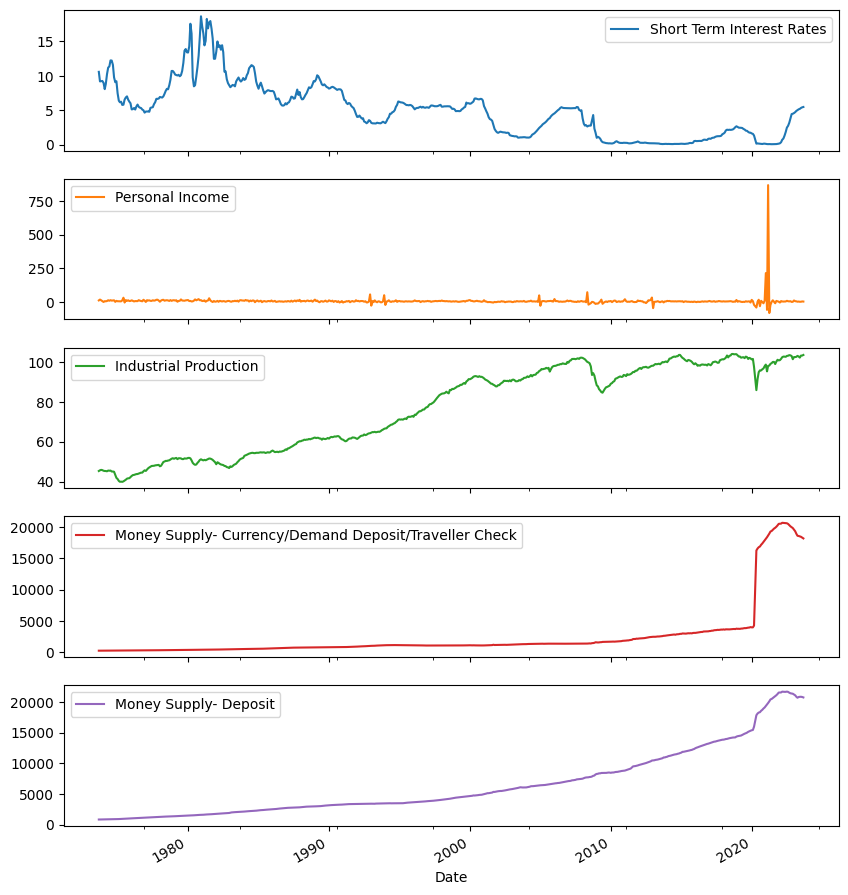

In [79]:
# plot the data all with dates on x-axis
df.plot(subplots=True, figsize=(10, 12))
plt.show()

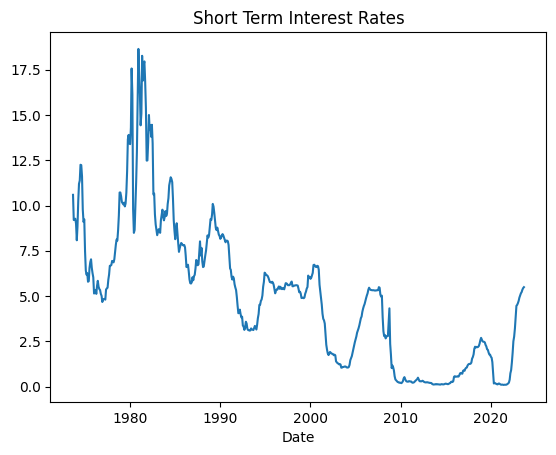

In [80]:
plt.plot(df.index, df["Short Term Interest Rates"])
plt.title("Short Term Interest Rates")
plt.xlabel("Date")
plt.show()

## Assessing Stationarity of Data
Augmented Dickey-Fuller (ADF) test: This is a statistical test that checks for the presence of a unit root in the time series data. A unit root indicates that the data is non-stationary. If the p-value of the test is less than a chosen significance level (e.g., 0.05), then the null hypothesis of a unit root is rejected and the data is considered stationary.

In [81]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["Short Term Interest Rates"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -2.282625
p-value: 0.177633
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569


We find that the data isnt stationary. To address that before going into our time-series modelling, we use Differencing: This involves taking the difference between consecutive observations in the time series. This can help remove trends and seasonality in the data.

In [82]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Take first difference of the time series
td = df["Short Term Interest Rates"].diff().dropna()

# Check if the time series is stationary
result = sm.tsa.adfuller(td)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -4.627927
p-value: 0.000115
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569


After the transformation the data exhibits stationarity as the p-value is lower than 0.05 and the ADF Statistic is lower than the 1% mark so we can proceed with our time-series modelling
________________________________________

The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots are used to identify the order of the AR (Autoregressive) and MA (Moving Average) terms in an ARIMA model.

The ACF plot shows the correlation between the time series and its lagged values. The PACF plot shows the correlation between the time series and its lagged values, after removing the effects of the intermediate lags.

Here's how to interpret the ACF and PACF plots:

ACF plot: If the ACF plot shows a sharp drop-off after a certain lag, it suggests that the time series is stationary and an AR model may be appropriate. If the ACF plot shows a gradual decay, it suggests that the time series may be non-stationary and a differencing operation may be required.

PACF plot: If the PACF plot shows a sharp drop-off after a certain lag, it suggests that an AR model may be appropriate. If the PACF plot shows a gradual decay, it suggests that an MA model may be appropriate.

Combined ACF and PACF plots: If the ACF plot shows a gradual decay and the PACF plot shows a sharp drop-off after a certain lag, it suggests that an ARMA model may be appropriate.

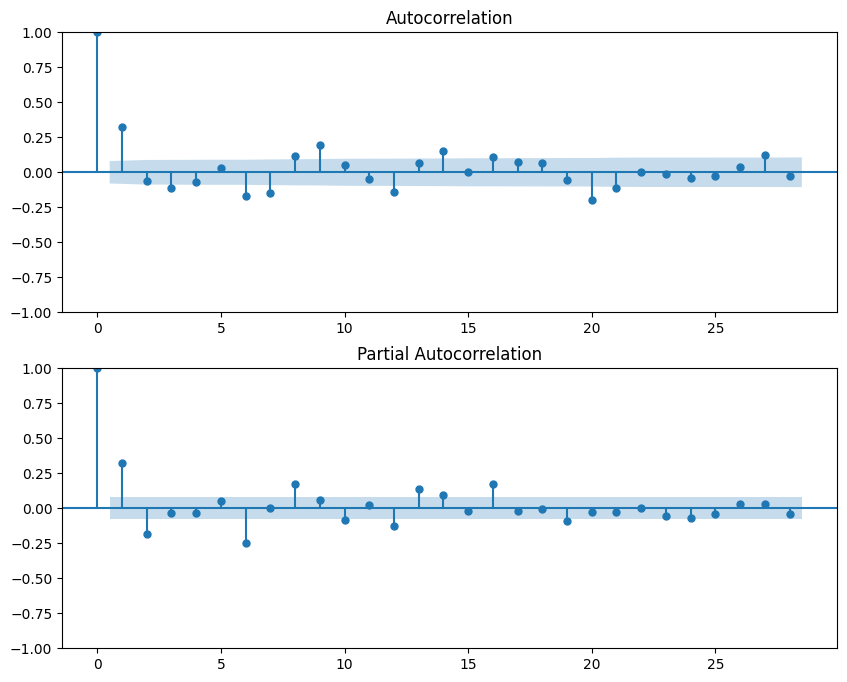

In [83]:
# Plot the ACF and PACF of the differenced time series
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(td, ax=ax[0])
plot_pacf(td, ax=ax[1])
plt.show()

In [84]:
# change td to pandas dataframe
td = pd.DataFrame(td)
df["Diff Short Term Interest Rates"] = td["Short Term Interest Rates"]

### Final Dataframe has the following Columns:

In [85]:
for i in df.columns:
    print(f"{i} with {df[i].count()} observations")

Short Term Interest Rates with 600 observations
Personal Income with 600 observations
Industrial Production with 600 observations
Money Supply- Currency/Demand Deposit/Traveller Check with 600 observations
Money Supply- Deposit with 600 observations
Diff Short Term Interest Rates with 599 observations


The desired task is to predict the future interest rate using previous observations. Feel free to use either the original version or the differentiated version (labeled as "Diff Short Term Interest Rates") which exhibits better stationarity.

In [94]:
# using scikit learn, split my data into training and testing sets (80/20) and make the test set the last 20% of the data

# df = df.iloc[::-1]

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

# Split the data into training and testing sets

# train_data = df[:'2013-01-01']

# test_data = df['2013-01-01':]

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

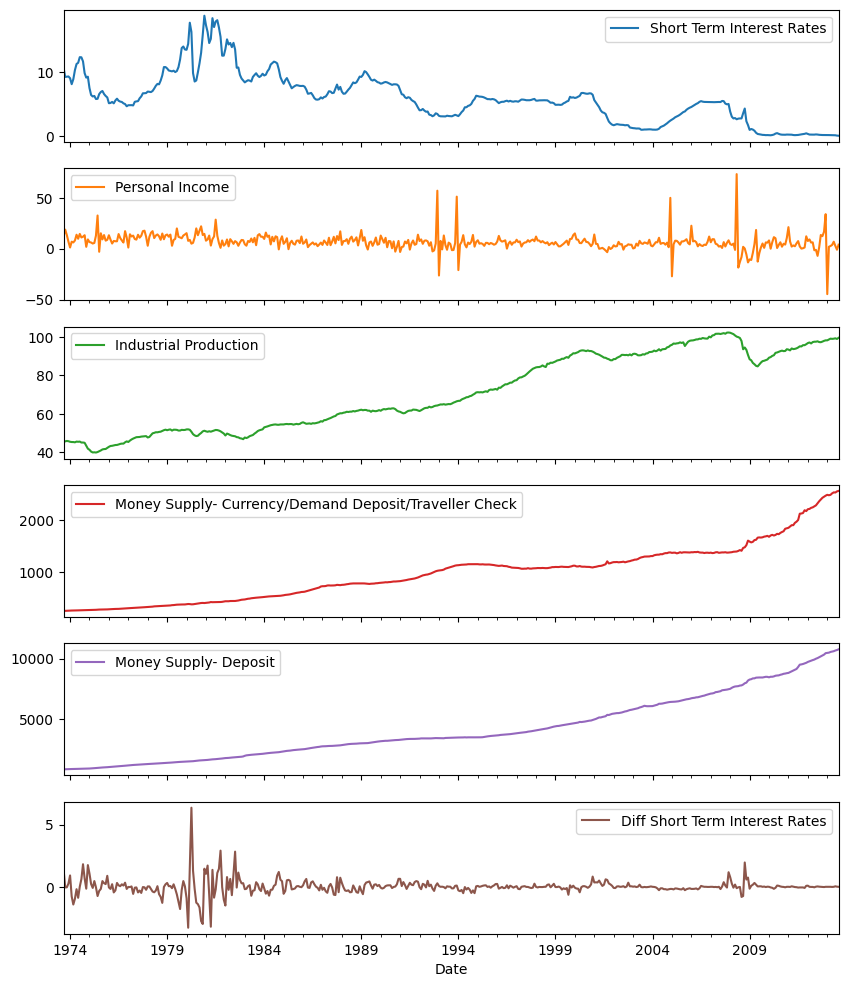

In [95]:
train_data.plot(subplots=True, figsize=(10, 12))

# Introduction to ARIMA for Time Series Forecasting

ARIMA, which stands for AutoRegressive Integrated Moving Average, is a widely used forecasting method for univariate time series data forecasting. ARIMA models take into account the past values to predict the future values. There are three important parameters in ARIMA:

1. **p (Autoregressive part)**: It incorporates the effect of past values into our model. Essentially, this part of the model suggests that the output variable depends linearly on its own previous values.

2. **d (Integrated part)**: This includes terms in the model that incorporate the amount of differencing to apply to a time series.

3. **q (Moving average part)**: This allows the regression error to be a linear combination of error terms whose values occurred contemporaneously and at various times in the past.

The ARIMA model works well on time series data that is stationary, which means the statistical properties of the series like mean, variance, autocorrelation, etc. are constant over time. 

# Rationale for Using ARIMA

The data we are working with can be considered as a time series. The ARIMA model is a good choice for this task because it can capture a suite of different standard temporal structures in time series data. 

The model can be tuned to meet the specifics of our dataset by changing the parameters (p, d, q) in the model. This makes ARIMA a flexible method that can be used for a wide range of time series data in various practical scenarios.

______________________________________

In this block below, we are performing a grid search to find the best parameters for an ARIMA model that forecasts short term interest rates. 

The ARIMA model is a type of time series model that combines differencing, autoregression, and a moving average model. It is defined by three parameters: p (the order of the autoregressive part), d (the order of differencing), and q (the order of the moving average part). 

We start by defining the range of values for p, d, and q as any integer between 0 and 2. We then generate all possible combinations of these three parameters.

Next, we initialize variables to store the best AIC (Akaike Information Criterion) value and the corresponding parameters. The AIC is a measure of the relative quality of a statistical model, with a lower AIC indicating a better model.

We then loop over all combinations of parameters. For each combination, we try to fit an ARIMA model to the training data. If the model fit is successful and its AIC is lower than the current best AIC, we update the best AIC and the best parameters.

After the grid search, we print the best parameters and the corresponding AIC. We then fit an ARIMA model with the best parameters to the training data and use it to generate forecasts for the test data.

The purpose of this script is to find the best ARIMA model for forecasting short term interest rates. By performing a grid search over a range of parameters, we can find the model that best fits our data according to the AIC.

In [96]:
import warnings

warnings.filterwarnings("ignore")

In [97]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Determine exogenous predictors
exogenous_predictors_train = train_data[
    [
        "Personal Income",
        "Industrial Production",
        "Money Supply- Currency/Demand Deposit/Traveller Check",
        "Money Supply- Deposit",
    ]
]
exogenous_predictors_test = test_data[
    [
        "Personal Income",
        "Industrial Production",
        "Money Supply- Currency/Demand Deposit/Traveller Check",
        "Money Supply- Deposit",
    ]
]

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
best_aic = np.inf
best_pdq = None
temp_model = ARIMA(
    train_data["Diff Short Term Interest Rates"],
    exog=exogenous_predictors_train,
    order=pdq[0],
)

for param in pdq:
    temp_model = ARIMA(
        train_data["Diff Short Term Interest Rates"],
        exog=exogenous_predictors_train,
        order=param,
    )
    results = temp_model.fit()
    if results.aic < best_aic:
        best_aic = results.aic
        best_pdq = param

print(f"Best ARIMA model is ARIMA{best_pdq} with AIC={best_aic}")

if best_pdq is not None:
    # Fit the best model
    best_model = ARIMA(
        train_data["Diff Short Term Interest Rates"],
        exog=exogenous_predictors_train,
        order=best_pdq,
    )
    results = best_model.fit()

    # Generate forecasts for the test data
    forecast = results.predict(
        start=len(train_data),
        end=len(train_data) + len(test_data) - 1,
        exog=exogenous_predictors_test,
    )
else:
    print("Could not find a suitable ARIMA model.")

Best ARIMA model is ARIMA(2, 0, 2) with AIC=839.5316863480405


In [98]:
train_data

,Short Term Interest Rates,Personal Income,Industrial Production,Money Supply- Currency/Demand Deposit/Traveller Check,Money Supply- Deposit,Diff Short Term Interest Rates
Date,,,,,,
1973-09-01,10.59,12.595892,45.391201,257.899994,839.299988,1.39
1973-10-01,9.20,18.755129,45.754200,259.000000,842.599976,-0.04
1973-11-01,9.24,13.365202,45.960602,261.000000,848.900024,-0.03
1973-12-01,9.27,6.867257,45.832100,262.899994,855.500000,0.27
1974-01-01,9.00,1.163929,45.529701,263.799988,859.700012,0.92
...,...,...,...,...,...,...
2013-04-01,0.20,3.732592,98.965797,2504.899902,10586.299810,0.00
2013-05-01,0.20,6.876735,99.056702,2523.500000,10621.000000,0.01
2013-06-01,0.19,2.707829,99.242401,2521.000000,10678.700200,0.05


```Up next, we visualize our results:```

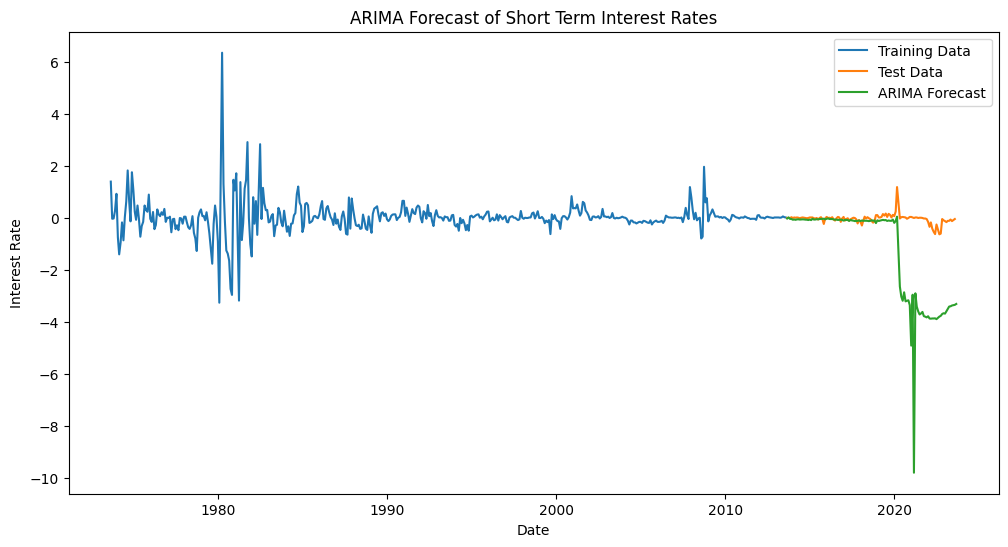

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(train_data["Diff Short Term Interest Rates"], label="Training Data")
plt.plot(test_data["Diff Short Term Interest Rates"], label="Test Data")
plt.plot(test_data.index, forecast, label="ARIMA Forecast")
plt.title("ARIMA Forecast of Short Term Interest Rates")
plt.xlabel("Date")
plt.ylabel("Interest Rate")
plt.legend()
plt.show()

```We measure model performance using Mean Square Error, Root Mean Square Error, Mean Absolute Error```

In [100]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate the errors
mae = mean_absolute_error(test_data["Short Term Interest Rates"], forecast)
mse = mean_squared_error(test_data["Short Term Interest Rates"], forecast)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 2.644967974715039
MSE: 13.597700107435083
RMSE: 3.6875059467660636


In [108]:
# df_orig = df_orig.iloc[::-1]
df_orig = df_orig.dropna()
df_orig

,Short Term Interest Rates,Personal Income,Industrial Production,Money Supply- Currency/Demand Deposit/Traveller Check,Money Supply- Deposit
Date,,,,,
2023-09-01,5.49,4.119065,103.611504,18171.400390,20754.900390
2023-08-01,5.44,5.019067,103.317001,18303.400390,20825.300780
2023-07-01,5.35,2.799455,103.289497,18428.000000,20863.699220
2023-06-01,5.22,2.565916,102.292397,18490.099610,20854.400390
2023-05-01,5.15,4.142010,102.849800,18559.800780,20820.400390
...,...,...,...,...,...
1974-01-01,9.00,1.163929,45.529701,263.799988,859.700012
1973-12-01,9.27,6.867257,45.832100,262.899994,855.500000
1973-11-01,9.24,13.365202,45.960602,261.000000,848.900024


In [118]:
# do the same using linear regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create the linear regression model
LinearModel = LinearRegression()

# train test split df_orig
# df_orig = df_orig.iloc[::-1]
train_lin, test_lin = train_test_split(df_orig, test_size=0.2, shuffle=False)

# Train the model
LinearModel.fit(
    train_lin[
        [
            "Personal Income",
            "Industrial Production",
            "Money Supply- Currency/Demand Deposit/Traveller Check",
            "Money Supply- Deposit",
        ]
    ],
    train_lin["Short Term Interest Rates"],
)

LinearRegression()

Linear Model 
MAE: 32.338797161989774
MSE: 2262.74566803391
RMSE: 47.568326311043464


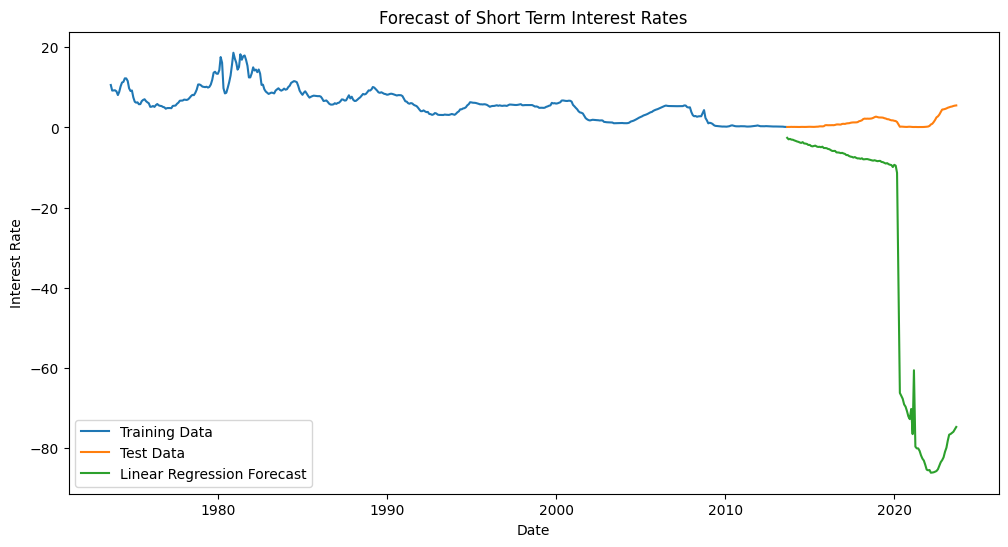

In [117]:
# Generate predictions for the test data
LinearForecast = LinearModel.predict(
    test_lin[
        [
            "Personal Income",
            "Industrial Production",
            "Money Supply- Currency/Demand Deposit/Traveller Check",
            "Money Supply- Deposit",
        ]
    ]
)

# Calculate the errors
linear_mae = mean_absolute_error(test_lin["Short Term Interest Rates"], LinearForecast)

linear_mse = mean_squared_error(test_lin["Short Term Interest Rates"], LinearForecast)
linear_rmse = np.sqrt(linear_mse)

print(f"Linear Model \nMAE: {linear_mae}")
print(f"MSE: {linear_mse}")
print(f"RMSE: {linear_rmse}")

# visualize the results

plt.figure(figsize=(12, 6))
plt.plot(train_lin["Short Term Interest Rates"], label="Training Data")
plt.plot(test_lin["Short Term Interest Rates"], label="Test Data")
# plt.plot(test_data.index, forecast, label='ARIMA Forecast')
plt.plot(test_lin.index, LinearForecast, label="Linear Regression Forecast")
plt.title("Forecast of Short Term Interest Rates")
plt.xlabel("Date")
plt.ylabel("Interest Rate")
plt.legend()
plt.show()

,Short Term Interest Rates,Personal Income,Industrial Production,Money Supply- Currency/Demand Deposit/Traveller Check,Money Supply- Deposit
Date,,,,,
2023-09-01,5.49,4.119065,103.611504,18171.400390,20754.900390
2023-08-01,5.44,5.019067,103.317001,18303.400390,20825.300780
2023-07-01,5.35,2.799455,103.289497,18428.000000,20863.699220
2023-06-01,5.22,2.565916,102.292397,18490.099610,20854.400390
2023-05-01,5.15,4.142010,102.849800,18559.800780,20820.400390
...,...,...,...,...,...
1984-01-01,9.42,9.599609,53.017502,525.099976,2138.199951
1983-12-01,9.69,11.747239,51.988602,521.400024,2123.500000
1983-11-01,9.36,11.766329,51.727001,519.000000,2112.300049


In [ ]:
# redo the arima without exogenous variables

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_pdq = None
temp_model = ARIMA(train_data["Diff Short Term Interest Rates"], order=pdq[0])

for param in pdq:
    temp_model = ARIMA(train_data["Diff Short Term Interest Rates"], order=param)
    results = temp_model.fit()
    if results.aic < best_aic:
        best_aic = results.aic
        best_pdq = param

print(f"Best ARIMA model is ARIMA{best_pdq} with AIC={best_aic}")

if best_pdq is not None:
    # Fit the best model
    best_model = ARIMA(train_data["Diff Short Term Interest Rates"], order=best_pdq)
    results = best_model.fit()

    # Generate forecasts for the test data
    forecast = results.predict(
        start=len(train_data), end=len(train_data) + len(test_data) - 1
    )

else:
    print("Could not find a suitable ARIMA model.")

Best ARIMA model is ARIMA(1, 0, 2) with AIC=832.155311679815


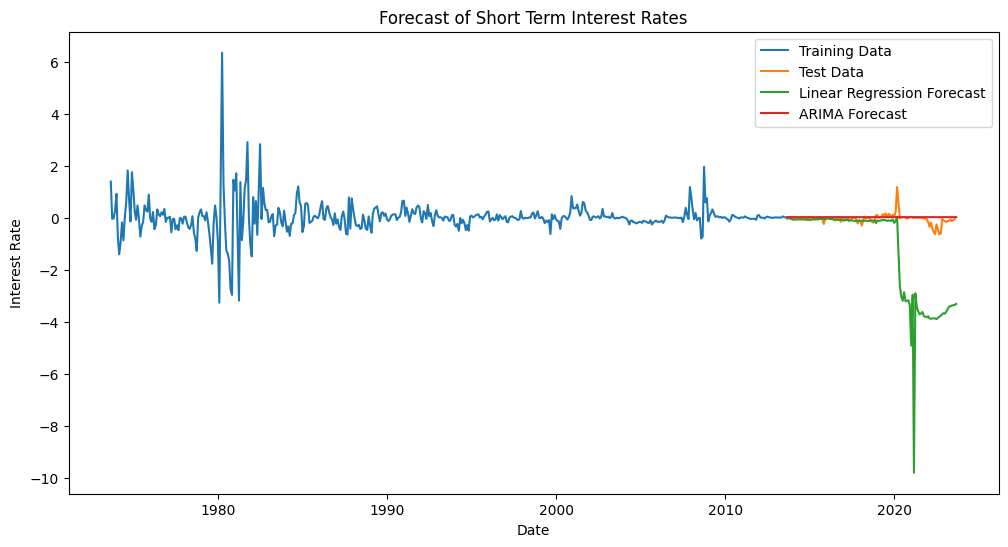

MAE: 1.302185499648753
MSE: 3.850776772971474
RMSE: 1.9623396171334548


In [ ]:
# visualize the results

plt.figure(figsize=(12, 6))
plt.plot(train_data["Diff Short Term Interest Rates"], label="Training Data")
plt.plot(test_data["Diff Short Term Interest Rates"], label="Test Data")
# plt.plot(test_data.index, forecast, label='ARIMA Forecast')
plt.plot(test_data.index, LinearForecast, label="Linear Regression Forecast")
plt.plot(test_data.index, forecast, label="ARIMA Forecast")
plt.title("Forecast of Short Term Interest Rates")
plt.xlabel("Date")
plt.ylabel("Interest Rate")
plt.legend()
plt.show()

# Calculate the errors
mae = mean_absolute_error(test_data["Short Term Interest Rates"], forecast)
mse = mean_squared_error(test_data["Short Term Interest Rates"], forecast)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

In [135]:
# Read in the data
interest_rates = pd.read_csv(
    r"Sample Project 1 - Interest Rate Prediction/daily-treasury-rates.csv",
    parse_dates=["Date"],
)

# drop columns with NAs
interest_rates = interest_rates.dropna(axis=1)

In [150]:
interest_rates = interest_rates.sort_values(by=["Date"], ascending=True)

In [157]:
# Convert the index to datetime
# interest_rates.set_index("Date", inplace=True)
interest_rates.index = pd.to_datetime(interest_rates.index)

# # Create a numerical "Day" column that represents the number of days since the start of the data
interest_rates["Day"] = (interest_rates.index - interest_rates.index[0]).days

# # Now you can use 'Day' as a predictor
X = interest_rates[["Day"]]
y = interest_rates["1 Mo"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create and train the linear regression model
LinearModel = LinearRegression()
LinearModel.fit(X_train, y_train)

LinearRegression()

In [156]:
interest_rates.index[2000]

,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,Day
Date,,,,,,,,,,,,
2012-01-03,0.01,0.02,0.06,0.12,0.27,0.40,0.89,1.41,1.97,2.67,2.98,0
2012-01-04,0.01,0.02,0.06,0.12,0.25,0.40,0.89,1.43,2.00,2.71,3.03,1
2012-01-05,0.01,0.02,0.07,0.11,0.27,0.40,0.88,1.43,2.02,2.74,3.06,2
2012-01-06,0.02,0.02,0.05,0.12,0.25,0.40,0.86,1.40,1.98,2.70,3.02,3
2012-01-09,0.01,0.01,0.05,0.11,0.26,0.38,0.85,1.39,1.98,2.70,3.02,6
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,5.51,5.53,5.47,5.36,4.87,4.57,4.29,4.27,4.18,4.48,4.29,4259
2023-09-05,5.51,5.55,5.51,5.42,4.94,4.65,4.37,4.35,4.27,4.56,4.38,4263
2023-09-06,5.52,5.55,5.52,5.44,5.01,4.73,4.44,4.39,4.30,4.56,4.37,4264


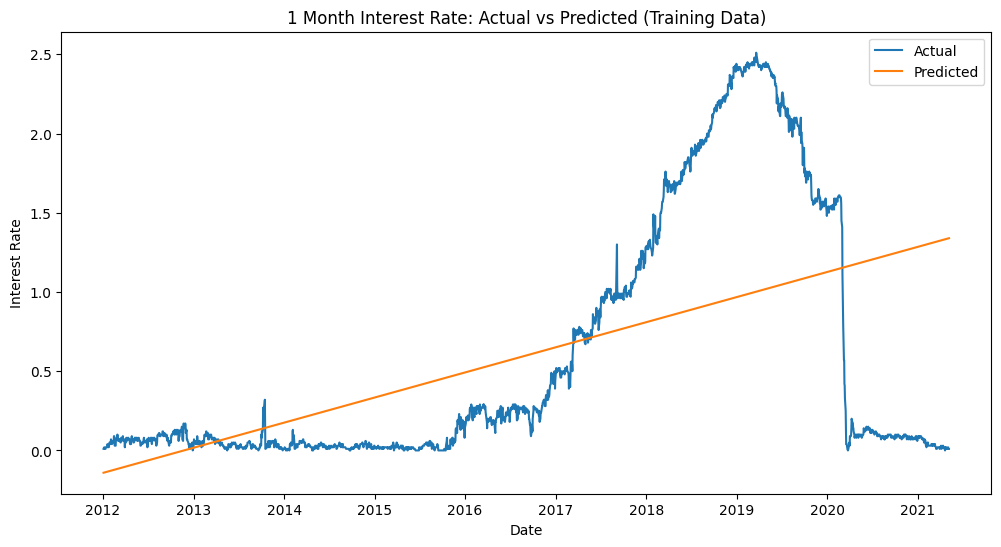

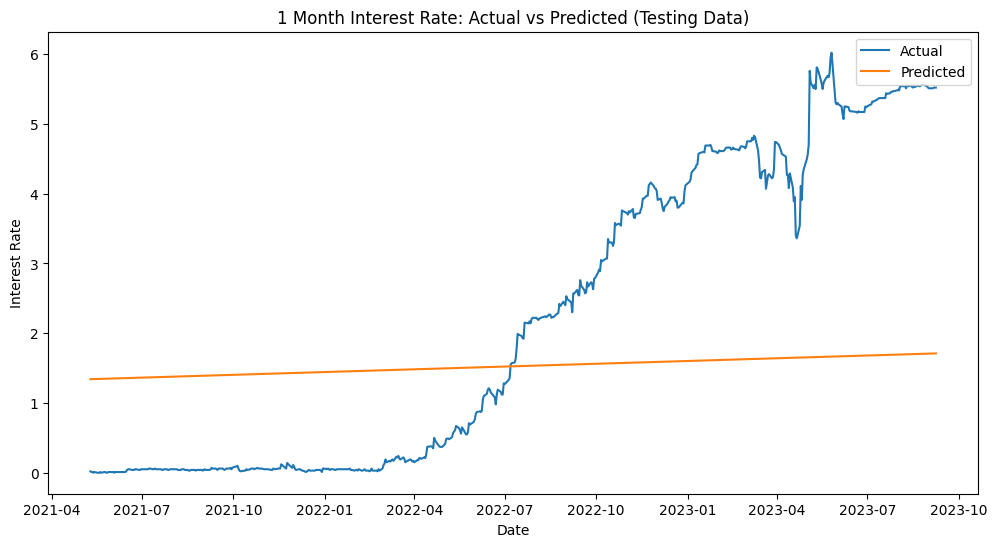

In [164]:
# Make predictions for both training and testing data
y_train_pred = LinearModel.predict(X_train)
y_test_pred = LinearModel.predict(X_test)

# Create DataFrames for plotting
train_plot_df = pd.DataFrame(
    {"Actual": y_train, "Predicted": y_train_pred}, index=X_train.index
)
test_plot_df = pd.DataFrame(
    {"Actual": y_test, "Predicted": y_test_pred}, index=X_test.index
)

# Plot the actual values and the predicted values for training data
plt.figure(figsize=(12, 6))
plt.plot(train_plot_df["Actual"], label="Actual")
plt.plot(train_plot_df["Predicted"], label="Predicted")
plt.title("1 Month Interest Rate: Actual vs Predicted (Training Data)")
plt.xlabel("Date")
plt.ylabel("Interest Rate")
plt.legend()
plt.show()

# Plot the actual values and the predicted values for testing data
plt.figure(figsize=(12, 6))
plt.plot(test_plot_df["Actual"], label="Actual")
plt.plot(test_plot_df["Predicted"], label="Predicted")
plt.title("1 Month Interest Rate: Actual vs Predicted (Testing Data)")
plt.xlabel("Date")
plt.ylabel("Interest Rate")
plt.legend()
plt.show()

In [ ]:
# split the data into training and testing sets (80/20) and make the test set the last 20% of the data

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(interest_rates, test_size=0.2, shuffle=False)

# Create the linear regression model

LinearModel = LinearRegression()